This notebook explores using a connected component algorithm to find coherent IVT anomalies.

In [3]:
""" Initialize the notebook """
%matplotlib inline
import pylab as PP
import matplotlib as mpl
import netCDF4 as nc
import glob
import datetime as dt
import sys
import os
from mpl_toolkits.basemap import Basemap, cm

from matplotlib import animation

import floodfillsearch.cFloodFillSearch as flood
import calculate_pressure_integral as vint

import numpy as np

import warnings
warnings.filterwarnings('ignore')


#Set the default font for plots
font = { 'family' : 'sans-serif', \
         'size' : '15', \
         'weight' : 'bold'}
mpl.rc('font', **font)
mpl.rc('axes', labelweight = 'bold') # needed for bold axis labels in more recent version of matplotlib

# turn on html5 animation by default
mpl.rc('animation', html='html5')

import os; print("{}:{}".format('cori',os.getcwd()))

cori:/global/u2/a/amahesh/climdeeplearn/climdeeplearn/ar_detection


In [4]:
""" Read in IVT data """

with nc.MFDataset("IWV*.nc") as fin:
    
    IVT = fin.variables['IVT'][:]
    IWV = fin.variables['IWV'][:]
    lat = fin.variables['lat'][:]
    lon = fin.variables['lon'][:]
    time = fin.variables['time'][:]
    time_units = fin.variables['time'].units

lon2d,lat2d = np.meshgrid(lon,lat)

In [5]:
""" Calculate IVT anomalies"""
# calculate the X-percentile anomalies for each timestep
IVT_time_percentile = 95
IVT_threshold = np.percentile(IVT,IVT_time_percentile,axis=(1,2))[:,np.newaxis,np.newaxis]

# damp anomalies to 0 near the tropics
sigma_lat = 10 # degrees
gaussian_band = 1 - np.exp(-lat2d**2/(2*sigma_lat**2))

# calculate IVT anomalies
IVT_anomaly = IVT*gaussian_band[np.newaxis,...] - IVT_threshold

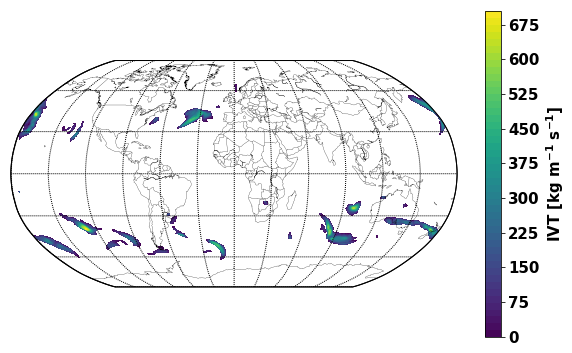

In [4]:
""" Plot IVT anomaly for the first timestep """
IVT_anomaly_plot = np.ma.masked_less(IVT_anomaly,0)

fig,ax = PP.subplots(figsize=(10,6))

# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='robin',lon_0=0.5*(lon[0]+lon[-1]),resolution='c',ax=ax)
# draw coastlines, country boundaries, fill continents.
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
# draw the edge of the map projection region (the projection limb)
m.drawmapboundary()
# draw lat/lon grid lines every 30 degrees.
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
# compute native map projection coordinates of lat/lon grid.
lon2d,lat2d = np.meshgrid(lon,lat)
x, y = m(lon2d*180./np.pi, lat2d*180./np.pi)
# contour data over the map.
cs = m.contourf(lon2d,lat2d,IVT_anomaly_plot[0,...],64,latlon=True)

fig.colorbar(cs,ax=ax,label='IVT [kg m$^{-1}$ s$^{-1}$]')
PP.show()

In [16]:
""" Run flood fill search """

ivt_blobs = flood.floodFillSearch(IVT_anomaly, wrapDimensions=[2])

In [17]:
""" Create an IVT blob array """

indrand = np.random.choice(10000,len(ivt_blobs))

ivt_blob_random_array = np.zeros(IVT.shape)

for i, blob in zip(indrand, ivt_blobs):
    
    ivt_blob_random_array[blob] = i + 1
    
ivt_blob_random_array = np.ma.masked_less_equal(ivt_blob_random_array,0)

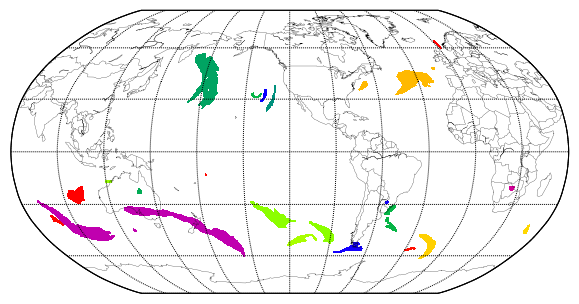

In [18]:
""" Plot IVT anomaly blobs for the first timestep """

fig,ax = PP.subplots(figsize=(10,6))

# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='robin',lon_0=-120,resolution='c',ax=ax)
# draw coastlines, country boundaries, fill continents.
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
# draw the edge of the map projection region (the projection limb)
m.drawmapboundary()
# draw lat/lon grid lines every 30 degrees.
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
# compute native map projection coordinates of lat/lon grid.
lon2d,lat2d = np.meshgrid(lon,lat)
x, y = m(lon2d*180./np.pi, lat2d*180./np.pi)
# contour data over the map.
cs = m.contourf(lon2d,lat2d,ivt_blob_random_array[0,...],64,latlon=True,cmap='prism')

#fig.colorbar(cs,ax=ax,label='IVT [kg m$^{-1}$ s$^{-1}$]')
PP.show()

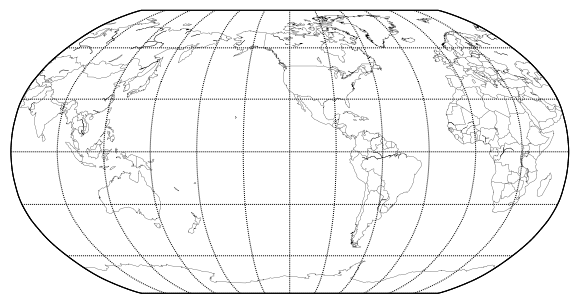

In [27]:


fig,ax = PP.subplots(figsize=(10,6))

# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='robin',lon_0=-120,resolution='c',ax=ax)
# draw coastlines, country boundaries, fill continents.
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
# draw the edge of the map projection region (the projection limb)
m.drawmapboundary()
# draw lat/lon grid lines every 30 degrees.
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
# compute native map projection coordinates of lat/lon grid.
lon2d,lat2d = np.meshgrid(lon,lat)
x, y = m(lon2d*180./np.pi, lat2d*180./np.pi)


# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are animating three artists, the contour and 2 
# annotatons (title), in each frame
ims = []
for i in range(len(ivt_blob_random_array[:,0,0])):
    im1 = m.contourf(lon2d,lat2d,IWV[i,:,:],latlon=True,cmap = 'binary_r',levels = np.arange(0,100,5))
    im2 = m.contourf(lon2d,lat2d,ivt_blob_random_array[i,:,:],alpha=0.5,latlon=True,cmap='prism',levels = np.arange(0,10000,100))
    add_arts1 = im1.collections
    add_arts2 = im2.collections
    datetime = nc.num2date(time[i],time_units)
    date = dt.date(datetime.year,datetime.month,datetime.day)
    text = str(date)
    an = ax.annotate(text, xy=(0.5, 1.05), xycoords='axes fraction',horizontalalignment='center')
    ims.append(add_arts1 + add_arts2 + [an])

anim = animation.ArtistAnimation(fig, ims)

#fig.clear()

anim




In [126]:
""" Define a class for calculating properties of a list of 3D blobs """

class BlobList3D:
    
    def __init__(self, \
                 blob_list, \
                 lat = None, \
                 lon = None, \
                 time = None, \
                ):
        """
            A class for calculating information about a list of list of contiguous points in data in time/lat/lon space
            
            input:
            ------
                blob_list : a list of list of indices of contiguous elements.  Should be compatible with output
                            from floodFillSearch
                            
                lat       : a vector of latitude values [degrees_north]
                
                lon       : a vector of longitude values [degrees_east]
                
                time      : a vector of time values ['time since ...' type units]
        
        """
        # save input variables
        self.blob_list = blob_list
        self.lat = lat
        self.lon = lon
        self.time = time
        
        # set constants
        self.rearth = 6.371e6 # m
        
        # initialize properties that can be calculated by methods here 
        self.area = None # self.calculate_grid_areas()
        self.blobs_by_time = None # self.sub_blobs_by_time()
        self.blob_areas_by_time = None # self.caculate_blob_areas_by_time()
        self.blob_max_areas = None # self.calculate_max_blob_areas()
        self.blob_centroids_by_time = None # calculate_blob_centroids()
            
    def calculate_centroid(self,ilats,ilons):
        """ Calculates the area-weighted average lat-lon of a blob.
        
            input:
            ------
                ilats : a vector of indices of latitudes
                
                ilons : a vector of indices of longitudes
                
            output:
            -------
            
                returns : a tuple of (lat,lon) corresponding to the centroid of the blob.
        
        """
        lats = self.lat[ilats]
        lons = self.lon[ilons]
        areas = self.area[(ilats,ilons)]
        
        # deal with longitude wrap-around
        if all(lons > 0) or all(lons < 0):
            # do nothing in the easy case where there is no wrap-around
            pass
        else:
            # find negative longitudes
            ineg = np.nonzero(lons < 0)[0]
            # copy the longitudes
            lons = np.array(lons,copy=True)
            # make longitudes all positive
            lons[ineg] += 360
            
        # calculate the average lat/lon
        lon_average = np.average(lons,weights = areas)
        lat_average = np.average(lats,weights = areas)
        
        # shift the average longitude back around if out of bounds
        if lon_average > 180:
            lon_average -= 360
        
        return (lat_average,lon_average)
        
            
    def calculate_grid_areas(self, area = None):
        """ Calculates the areas of all grid cells. 
        
            input:
            ------
                None
                
            output:
            -------
        
                returns : a 2D array of all cell areas
                
                sets self.area
        """
        
        # check that we have lat/lon vectors
        if self.lat is None or self.lon is None:
            raise RuntimeError("self.lat and self.lon need to be set in order to calculate area")
            
        # convert to radians
        theta = self.lat*np.pi/180
        phi = self.lon*np.pi/180
        
        # calculate latitude spacing
        dtheta = np.diff(theta)
        dtheta = np.concatenate(([dtheta[0]],dtheta))
        # calculate longitude spacing
        dphi = np.diff(phi)
        dphi = np.concatenate(([dphi[0]],dphi))
        
        # create 2D arrays of lat/lon and lat/lon spacing
        phi2d,theta2d = np.meshgrid(phi,theta)
        dlon2d,dtheta2d = np.meshgrid(dphi,dtheta)
        
        # calculate cell areas and save to the instance
        self.area = np.cos(theta2d)*dtheta2d*dlon2d*self.rearth**2
        
        # return areas
        return self.area
    
    def sub_blobs_by_time(self):
        """Subsets each blob by time.
        
            input:
            ------
                None
                
            output:
            ------
            
                returns : a list of dictionaries, where each dictionary corresponds to a blob, and each item
                          in each dictionary contains a tuple of latitude indices and longitude indices
                          
                          [ { 0 : (lat_ind_array,lon_ind_array), 1 : (...) }, ...]
                          
                sets self.blobs_by_time
        
        """
        
        # initialize the output array
        blobs_by_time = []
        
        # loop over blobs
        for blob in self.blob_list:
            
            # get the list of unique times for inices within this blob and the number of times each time occurs
            unique_times,unique_counts = np.unique(blob[0],return_counts = True)
            
            # initialize the dictionary of blob incides
            current_dict = { t : (np.zeros(c,dtype=int), np.zeros(c,dtype=int)) for t,c in zip(unique_times,unique_counts) }
            
            # initialize a counter used for setting blob index values
            counters = {t : 0 for t in unique_times}
            
            # loop over time, lat, lon indices in this blob
            for t,y,x in zip(*blob):
                # set the lat/lon indices for this timestep
                current_dict[t][0][counters[t]] = y
                current_dict[t][1][counters[t]] = x
                
                # increment the counter for this timestep
                counters[t] += 1
            
            # add this blob's dictionary to the running list
            blobs_by_time.append(current_dict)
            
        # save the list to the object
        self.blobs_by_time = blobs_by_time
        
        # return the list
        return blobs_by_time
        
        
    def caculate_blob_areas_by_time(self):
        """ Calculates blob areas for each timestep.
        
            input:
            ------
                None
                
            output:
            ------
            
                returns : a list of dictionaries, where each dictionary corresponds to a blob, and each item
                          in each dictionary contains the area of the blob
                          
                          [ { 0 : area1, 1 : area2 }, ...]
                          
                sets self.blob_areas_by_time
        
        """
        # calculate grid areas if needed
        if self.area is None:
            self.calculate_grid_areas()
            
        # get sub blobs by time if needed
        if self.blobs_by_time is None:
            self.sub_blobs_by_time()
        

        # initialize the output array
        blob_areas_by_time = []
        
        # loop over the time-sorted blob areas
        for blob_time_dict in self.blobs_by_time:
            # calculate the area for each timestep within this blob
            areas_by_time = {t : np.sum(self.area[blob_time_dict[t]]) for t in blob_time_dict}
            
            # add this dictionary of areas to the list
            blob_areas_by_time.append(areas_by_time)
            
        # save the list to the instance
        self.blob_areas_by_time = blob_areas_by_time
        
        # return the list
        return blob_areas_by_time
    
    def calculate_max_blob_areas(self):
        """ Calculates maximum blob areas for each blob.
        
            input:
            ------
                None
                
            output:
            ------
            
                returns : a list where each item corresponds to a blob's maximum area over its lifetime
                          
                          [ maxarea1, maxarea2, ...]
                          
                sets self.blob_max_areas
        
        """
        # get areas by time if needed
        if self.blob_areas_by_time is None:
            self.caculate_blob_areas_by_time()
            
        # initialize the output variable
        blob_max_areas = []
        
        # loop over blobs
        for areas_by_time in self.blob_areas_by_time:
            # determine the max area for this blob
            max_area = np.max([areas_by_time[t] for t in areas_by_time])
            
            # append it to the list
            blob_max_areas.append(max_area)
            
        # save the list to the instance
        self.blob_max_areas = blob_max_areas
        
        # return  the list
        return blob_max_areas
    
    def calculate_blob_centroids(self):
        """ Calculates the centroid of each blob
        
            input:
            ------
                None
                
            output:
            ------
            
                returns : a list of dictionaries tuples, where each dictionary contains a tuple for each time index
                          that the blob exists
                          
                          [ { 0 : (lat1,lon1), 1 : (lat2,lon2) }, ...]
                          
                sets self.blob_centroids_by_time
        
        """
        # get blobs by time if needed
        if self.blobs_by_time is None:
            self.sub_blobs_by_time()
            
        # initialize the output variable
        blob_centroids_by_time = []
                        
        # loop over blobs
        for blob_time_dict in self.blobs_by_time:
            # get the center lat/lon of each blob
            centroids_by_time = {t : self.calculate_centroid(*blob_time_dict[t]) for t in blob_time_dict}
            
            # append the dictionary of centroids to the list
            blob_centroids_by_time.append(centroids_by_time)
            
        # store the list in the instance
        self.blob_centroids_by_time = blob_centroids_by_time
        
        # return the list
        return blob_centroids_by_time
    
    def get_blob_centroids_per_time(self):
        """ Returns a list of all blob centroids for all times.
        
            input:
            ------
                None
                
            output:
            ------
            
                returns : a list of tuples, where each item corresponds to the centroids of all blobs at that time
                          index.  Has the same length as self.time
                          
                          [ (latarray1,lonarray1), (latarray2,lonarray2), ...]
                          
                sets self.blob_centroids_by_time
        
        """
        # check that we have the time vector
        if self.time is None:
            raise RuntimeError("self.time needs to be set in order to organize blobs by time")
            
        # get the list of dictionaries of blob centroids
        if self.blob_centroids_by_time is None:
            self.calculate_blob_centroids()
        
        # initialize the output list
        centroids_per_time = []
        
        # loop over all times
        for t in range(len(self.time)):

            # get the list of centroids within this timestep
            centroids_this_time = [blob_centroid_dict[t] for blob_centroid_dict in self.blob_centroids_by_time if t in blob_centroid_dict ]
            
            # convert the list of centroid tuples into lists of lats and lons
            centroid_lats,centroid_lons = zip(*centroids_this_time)
            
            # add a tuple of lat/lon vectors to the list
            centroids_per_time.append((np.array(centroid_lats),np.array(centroid_lons)))
            
        # store the list in the instance
        self.centroids_per_time = centroids_per_time
            
        # return the list
        return centroids_per_time


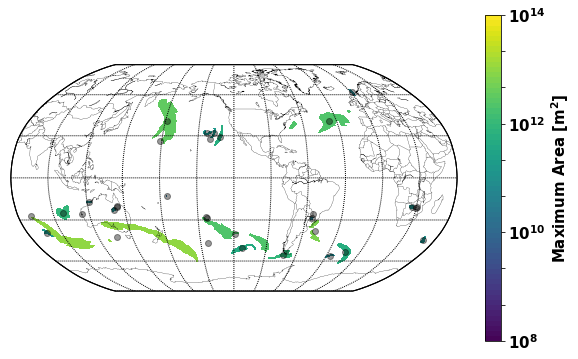

In [128]:
""" Color blobs by max area """

blobclass = BlobList3D(ivt_blobs,lat,lon,time)

blob_max_areas = blobclass.calculate_max_blob_areas()

blob_centroids = blobclass.get_blob_centroids_per_time()

ivt_blob_area_array = np.zeros(IVT.shape)

for a, blob in zip(blob_max_areas, ivt_blobs):
    
    ivt_blob_area_array[blob] = a
    
ivt_blob_area_array = np.ma.masked_less_equal(ivt_blob_area_array,0)

""" Plot IVT anomaly blobs for the first timestep """

fig,ax = PP.subplots(figsize=(10,6))

# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='robin',lon_0=-120,resolution='c',ax=ax)
# draw coastlines, country boundaries, fill continents.
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
# draw the edge of the map projection region (the projection limb)
m.drawmapboundary()
# draw lat/lon grid lines every 30 degrees.
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
# compute native map projection coordinates of lat/lon grid.
lon2d,lat2d = np.meshgrid(lon,lat)
x, y = m(lon2d*180./np.pi, lat2d*180./np.pi)
# contour data over the map.
levels = np.logspace(8,14,64)
cs = m.contourf(lon2d,lat2d,ivt_blob_area_array[0,...],64,latlon=True,locator=mpl.ticker.LogLocator(),levels=levels)

clons = blob_centroids[0][1]
clats = blob_centroids[0][0]
cx,cy = m(clons,clats)
m.plot(cx,cy,'ko',alpha=0.4)

fig.colorbar(cs,ax=ax,label='Maximum Area [m$^2$]')
PP.show()

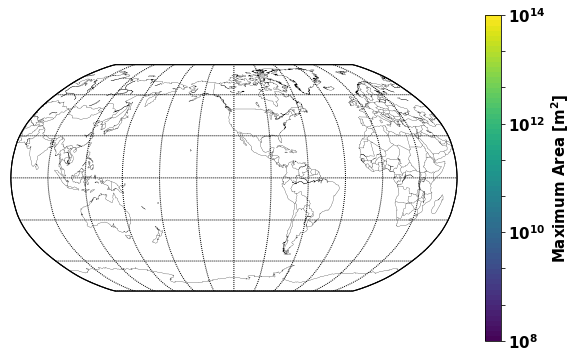

In [70]:
fig,ax = PP.subplots(figsize=(10,6))

# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='robin',lon_0=-120,resolution='c',ax=ax)
# draw coastlines, country boundaries, fill continents.
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
# draw the edge of the map projection region (the projection limb)
m.drawmapboundary()
# draw lat/lon grid lines every 30 degrees.
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
# compute native map projection coordinates of lat/lon grid.
lon2d,lat2d = np.meshgrid(lon,lat)
x, y = m(lon2d*180./np.pi, lat2d*180./np.pi)

levels = np.logspace(10,13,64)

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are animating three artists, the contour and 2 
# annotatons (title), in each frame
ims = []
for i in range(len(ivt_blob_random_array[:,0,0])):
    im1 = m.contourf(lon2d,lat2d,IWV[i,:,:],latlon=True,cmap = 'binary_r',levels = np.arange(0,100,5))
    im2 = m.contourf(lon2d,lat2d,ivt_blob_area_array[i,...],latlon=True,locator=mpl.ticker.LogLocator(),levels=levels)

    add_arts1 = im1.collections
    add_arts2 = im2.collections
    datetime = nc.num2date(time[i],time_units)
    date = dt.date(datetime.year,datetime.month,datetime.day)
    text = str(date)
    an = ax.annotate(text, xy=(0.5, 1.05), xycoords='axes fraction',horizontalalignment='center')
    ims.append(add_arts1 + add_arts2 + [an])

fig.colorbar(cs,ax=ax,label='Maximum Area [m$^2$]')
    
anim = animation.ArtistAnimation(fig, ims)

#fig.clear()

anim

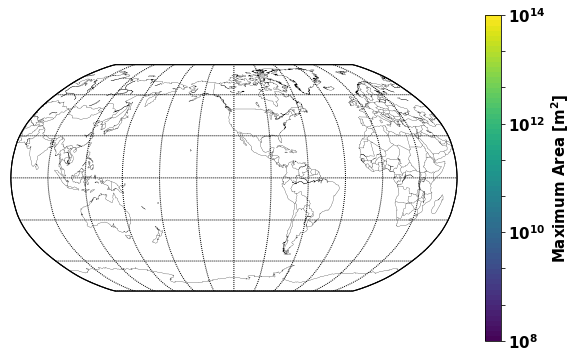

In [73]:
area_threshold = 5e11
ivt_ar_area = np.ma.masked_less(ivt_blob_area_array,area_threshold)

fig,ax = PP.subplots(figsize=(10,6))

# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='robin',lon_0=-120,resolution='c',ax=ax)
# draw coastlines, country boundaries, fill continents.
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
# draw the edge of the map projection region (the projection limb)
m.drawmapboundary()
# draw lat/lon grid lines every 30 degrees.
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
# compute native map projection coordinates of lat/lon grid.
lon2d,lat2d = np.meshgrid(lon,lat)
x, y = m(lon2d*180./np.pi, lat2d*180./np.pi)

levels = np.logspace(10,13,64)


# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are animating three artists, the contour and 2 
# annotatons (title), in each frame
ims = []
for i in range(len(ivt_blob_random_array[:,0,0])):
    im1 = m.contourf(lon2d,lat2d,IWV[i,:,:],latlon=True,cmap = 'binary_r',levels = np.arange(0,100,5))
    im2 = m.contourf(lon2d,lat2d,ivt_ar_area[i,...],latlon=True,locator=mpl.ticker.LogLocator(),levels=levels)

    add_arts1 = im1.collections
    add_arts2 = im2.collections
    datetime = nc.num2date(time[i],time_units)
    date = dt.date(datetime.year,datetime.month,datetime.day)
    text = str(date)
    an = ax.annotate(text, xy=(0.5, 1.05), xycoords='axes fraction',horizontalalignment='center')
    ims.append(add_arts1 + add_arts2 + [an])

fig.colorbar(cs,ax=ax,label='Maximum Area [m$^2$]')
    
PP.ion()
anim = animation.ArtistAnimation(fig, ims)

#fig.clear()

anim